elif criteria_precipitation[i] == True:
            label_image[mask == obj.label] = 2
        else:
            label_image[mask == obj.label] = 0
    label_image[label_image == 0] = np.nan

In [3]:
%pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [228]:
import xarray as xr
import cmweather
import skimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import urllib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from PIL import Image
%matplotlib inline

## Load the data

In [517]:
ds = xr.open_mfdataset('/Users/aabdelbak/20240109/crocus*20240109*.nc')
ds['velocity'] = (['spectrum_n_samples'], np.linspace(0, ds['VEL'].attrs['fold_limit_upper'], 64))
ds['range_spectra'] = (['n_spectra'], ds['range'].values)
ds = ds.set_coords(['range_spectra', 'velocity'])

In [518]:
ds

<xarray.Dataset>
Dimensions:                 (time: 8280, range: 128, sweep: 1, n_spectra: 128,
                             spectrum_n_samples: 64)
Coordinates:
  * range                   (range) float32 0.0 35.0 70.0 ... 4.41e+03 4.445e+03
  * time                    (time) datetime64[ns] 2024-01-09T00:00:00.0061629...
    elevation               (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    azimuth                 (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    velocity                (spectrum_n_samples) float64 0.0 0.1887 ... 11.89
    range_spectra           (n_spectra) float32 0.0 35.0 ... 4.41e+03 4.445e+03
Dimensions without coordinates: sweep, n_spectra, spectrum_n_samples
Data variables: (12/31)
    volume_number           (time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    time_coverage_start     (time) |S128 b'2024-01-09T00:00:00Z' ... b'2024-0...
    time_coverage_end       (time) |S128 b'2024-01-09T00:59:50Z' ... b'2024-0...
    time_reference          (time) |S128 b'1970-01-01T00:00:00Z' ... b'1970-0...
    instrument_type         (time) |S128 b'radar' b'radar' ... b'radar' b'radar'
    transfer_function       (time, range) float64 dask.array<chunksize=(360, 128), meta=np.ndarray>
    ...                      ...
    ML                      (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    SNR                     (time, range) float32 dask.array<chunksize=(1, 128), meta=np.ndarray>
    index_spectra           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    spectrum_raw            (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
    N                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
    D                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(360, 128, 64), meta=np.ndarray>
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data
    institution:      
    references:       
    source:           
    history:          
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      Za,Z,Zea,Ze,RR,LWC,PIA,VEL,WIDTH,SNR,spectrum_reflectiv...

## View a raw spectrum

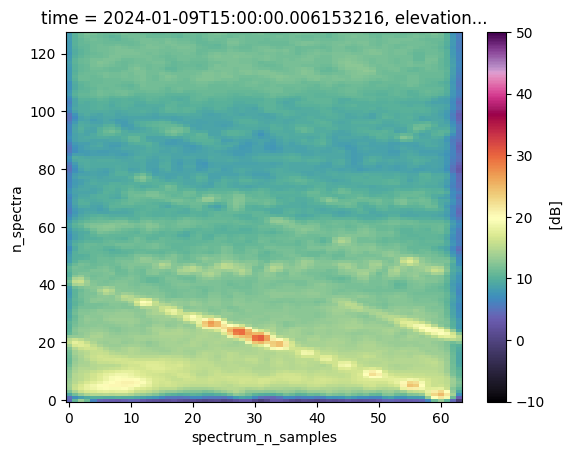

In [519]:
ds['spectrum_raw'].sel(time='2024-01-09T015:00:00').plot(cmap='ChaseSpectral', vmin=-10, vmax=50)

## Subtract the background noise from each spectrum

We want to look at interference which stands out from noise. 
Therefore, we need to take into account the signal noise first, which changes as a function of range. It also changes throughout the 
project. Some time periods have been seen to have signal noise on the order of 20-30 dBZ...which does not fare well for useful observations.

In [520]:
ds['snr_spectrum'] = 10**(ds['spectrum_raw']/10) / 10**(ds['spectrum_raw'].median(dim='spectrum_n_samples')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])

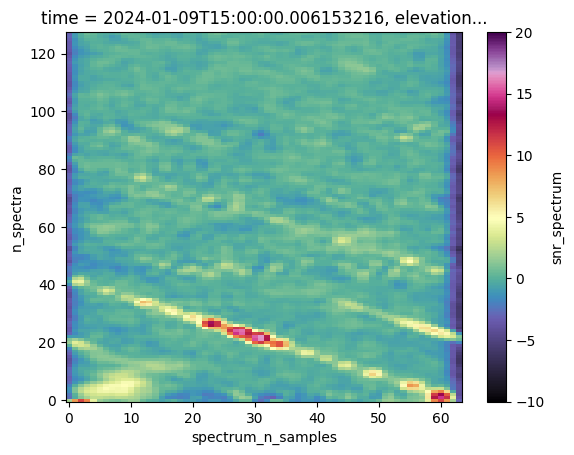

In [521]:
ds['snr_spectrum'].sel(time='2024-01-09T15:00:00').plot(cmap='ChaseSpectral', vmin=-10, vmax=20)

## Code to automatically generate the interference masks

This code will print out a figure with auto-generated interference masks. It uses image segmentation on the noise subtracted Doppler spectra to do so. It will look at the area, major and minor axis of the ellipse surrounding the region, and the ellipse orientation to examine whether the region is interference or precipitation. Note that this algorithm is not able to distinguish mixed precip+interference regions. T

In [524]:
def gen_spectral_masks(image_time):
    input_image = ds['snr_spectrum'].sel(time=image_time).values.squeeze()
    
    # Right now, require the signal-to-noise ratio to be > 1 dB. Adjust as you see fit to include lighter precipitation
    # Be aware that lowering this threshold is more likely to introduce noise as real values, so there is a trade off here!
    input_mask = input_image > 1.5
    label_image = skimage.measure.label(input_mask)

    # Get the properties of each region
    props = skimage.measure.regionprops(label_image)
    mask = label_image.copy()
    label_image = np.zeros_like(mask).astype(float)
    
    orientation = np.array([np.rad2deg(p.orientation) for p in props])
    area = np.array([p.area for p in props])
    major_axis_length = np.array([p.major_axis_length for p in props])
    minor_axis_length = np.array([p.minor_axis_length for p in props])
    axis_ratio = major_axis_length / minor_axis_length
    height = np.array([p.bbox[3] - p.bbox[1] for p in props])

    area_thresh = 25

    # Create Red and blue colormap
    cmap_custom = np.zeros((2, 4))
    cmap_custom[0] = np.array([1., 0., 0., 0])
    cmap_custom[1] = np.array([0., 1., 0., 0])
    cmap_redblue = colors.ListedColormap(cmap_custom, N=2)
    
    ## Insert your criteria here
    # Right now, we are considering any region with > 40 deg orientation and whose longest axis is 3 x the minor axis 
    # To be interference. This covers the coherent noise that appears as diagonal lines. 
    # In addition, we also consider any region with > 70 deg orientation (near horizontal) as interference
    # This covers the random interference that appears as a horizontal region.
    # Precipitation is typically much more vertical in nature in the spectra
    criteria_interference = np.logical_and(np.abs(orientation) > 45, axis_ratio > 3)
    criteria_interference = np.logical_or(criteria_interference, np.abs(orientation) > 80)
    criteria_interference = np.logical_and(criteria_interference, area > area_thresh)
    criteria_precipitation = np.logical_and(np.abs(orientation) < 40, area > area_thresh)
    
    for i, obj in enumerate(props):
        if criteria_interference[i] == True:
            label_image[mask == obj.label] = 1
        else:
            label_image[mask == obj.label] = 0
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ds['spectrum_raw'].sel(time=image_time).plot(cmap='ChaseSpectral', vmin=-10, vmax=50, ax=ax, x='velocity', y='range_spectra',
                                            cbar_kwargs={'pad': 0.1})
    x, y = np.meshgrid(ds['velocity'], ds['range_spectra'])
    c = plt.pcolormesh(x, y, label_image, alpha=0.5, cmap=cmap_redblue)
    x, y = np.meshgrid(ds['velocity'], ds['range_spectra'], indexing='ij')
    
    ax.set_title(image_time)
    ax.set_xlim([0, 12])
    ax.set_ylabel('Range [m]')
    ax.set_xlabel('Doppler velocity [m/s]')
    cbar = fig.colorbar(c, ax=ax, orientation="horizontal", pad=0.1)
    cbar.ax.set_xticks([1, 2])
    cbar.ax.set_xlim([1, 2])
    cbar.ax.set_xticklabels(["Interference", "Precipitation"])
    fig.tight_layout()
    time_str = ds['time'].sel(time=image_time).dt.strftime('%Y%m%d.%H%M%S').values
    fig.savefig('interference_masks/%s.png' % time_str[0], bbox_inches='tight')
    print(label_image)
    interference_mask = np.where(label_image == 1, 1, 0)
    np.save('interference_mask.npy', interference_mask)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


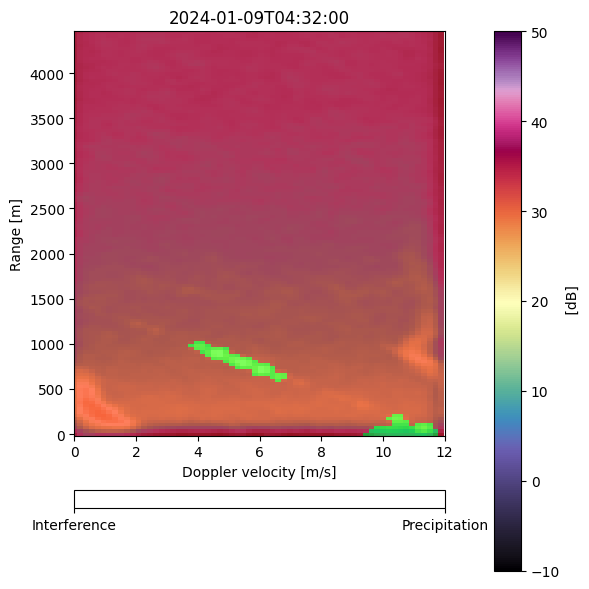

In [463]:
image_time = '2024-01-09T04:32:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


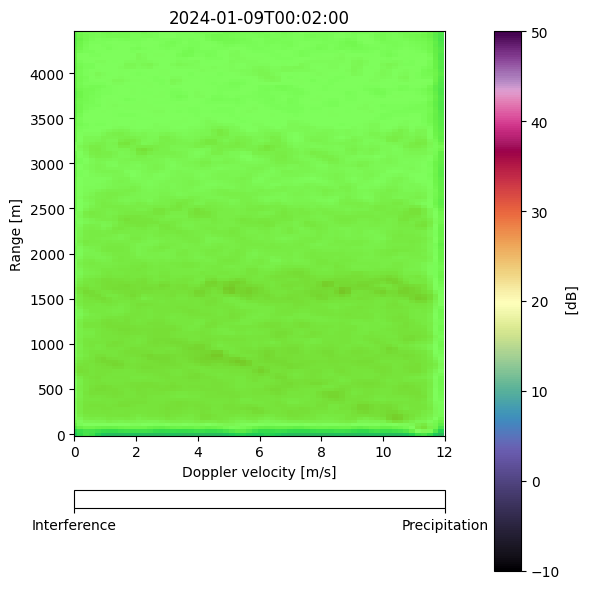

In [464]:
image_time = '2024-01-09T00:02:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


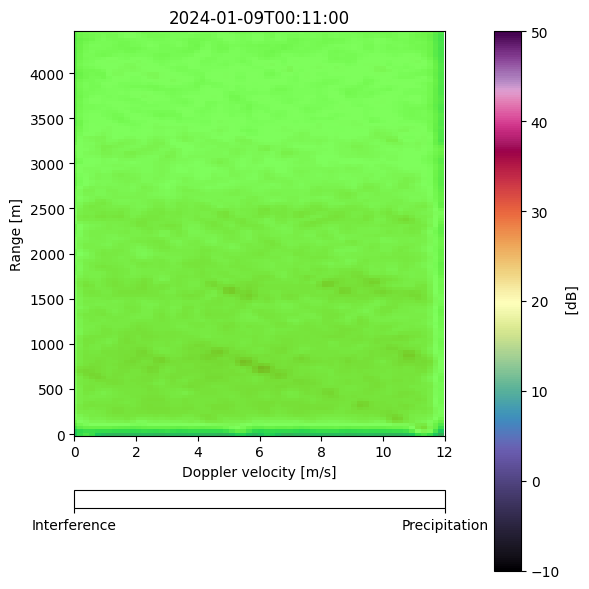

In [465]:
image_time = '2024-01-09T00:11:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


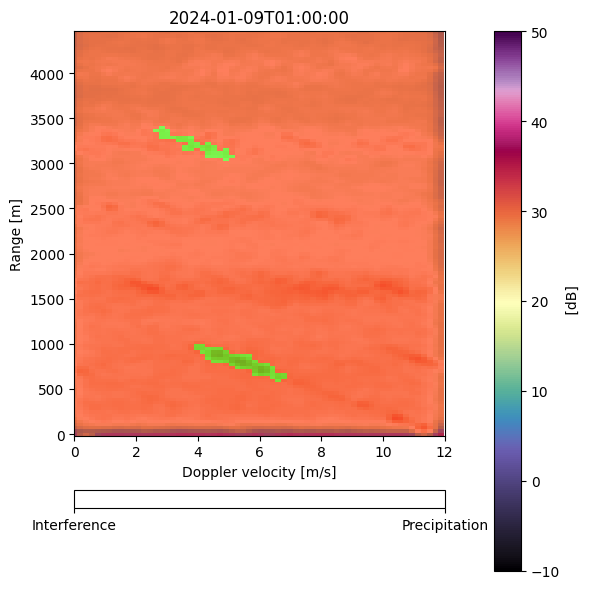

In [466]:
image_time = '2024-01-09T01:00:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


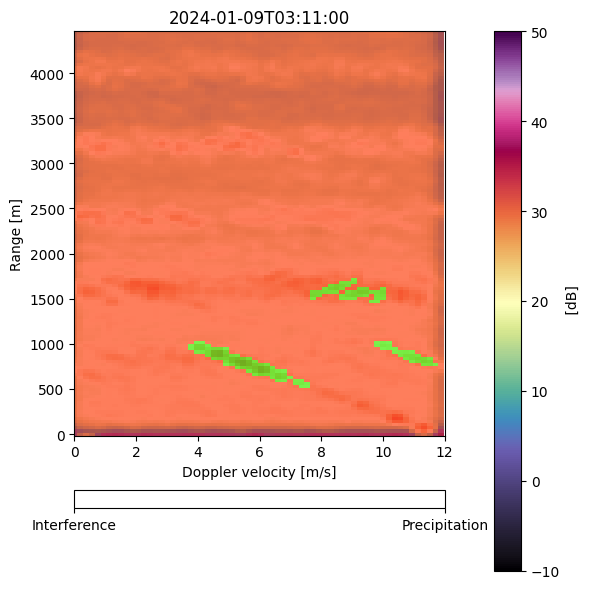

In [467]:
image_time = '2024-01-09T03:11:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


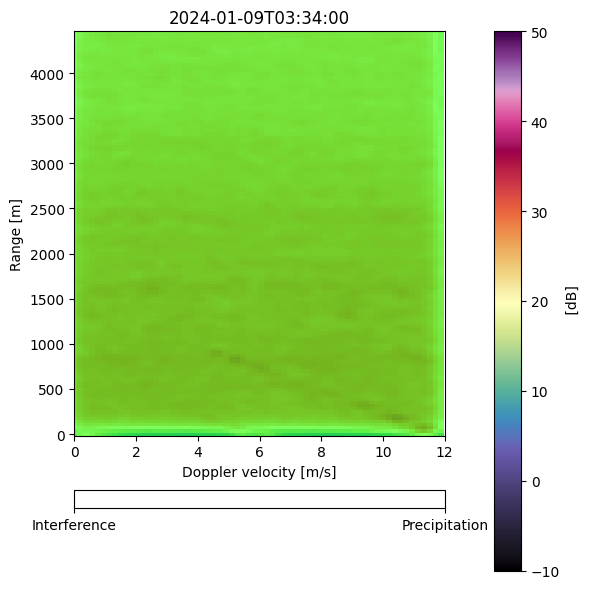

In [468]:
image_time = '2024-01-09T03:34:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/1196638901.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/1196638901.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


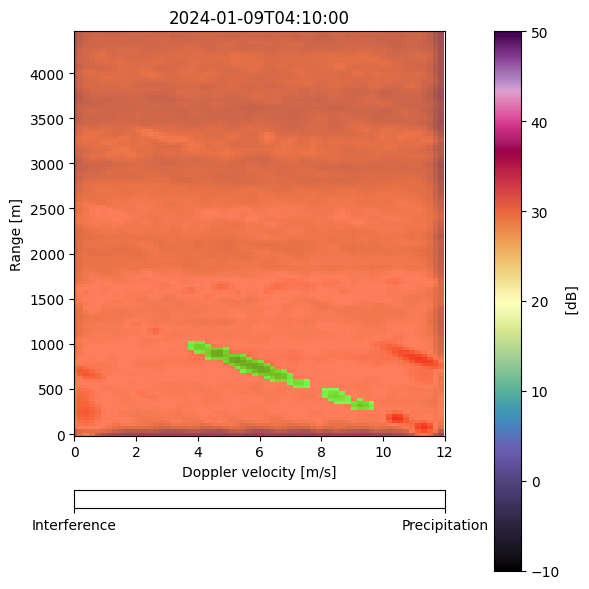

In [516]:
image_time = '2024-01-09T04:10:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


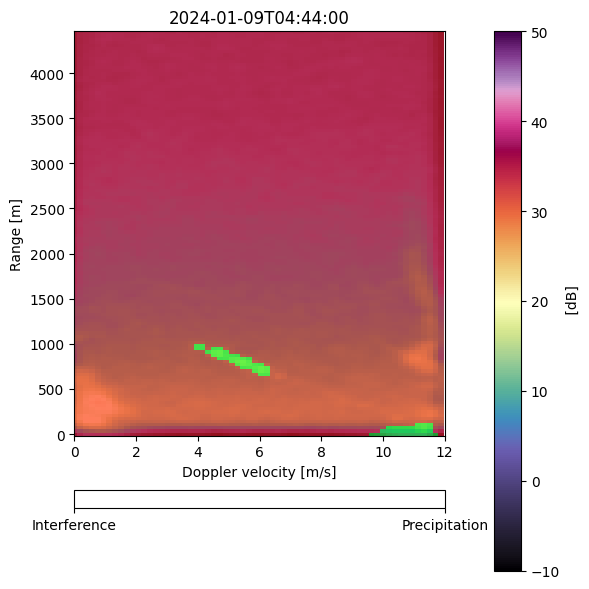

In [470]:
image_time = '2024-01-09T04:44:00'
mask = gen_spectral_masks(image_time)

[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


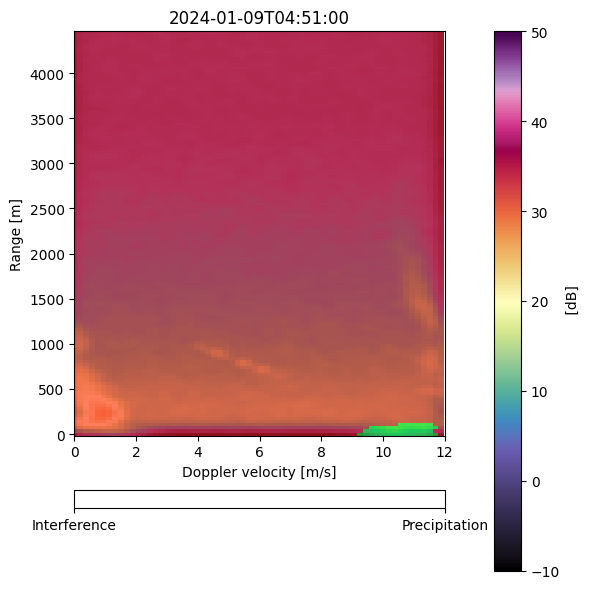

In [471]:
image_time = '2024-01-09T04:51:00'
mask = gen_spectral_masks(image_time)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


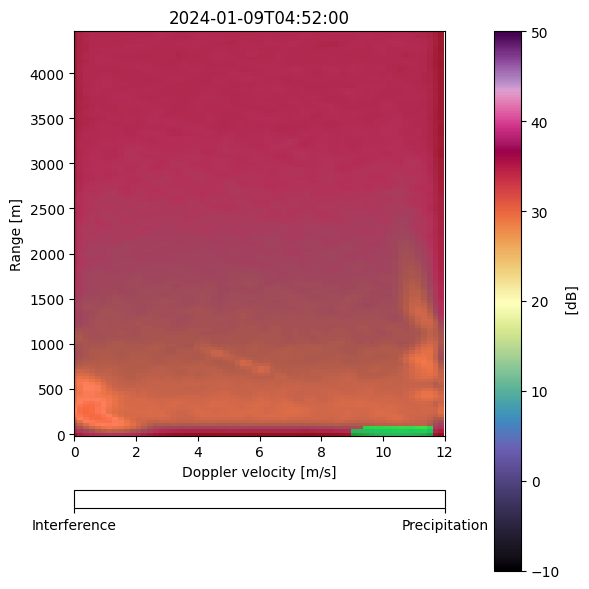

In [472]:
image_time = '2024-01-09T04:52:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


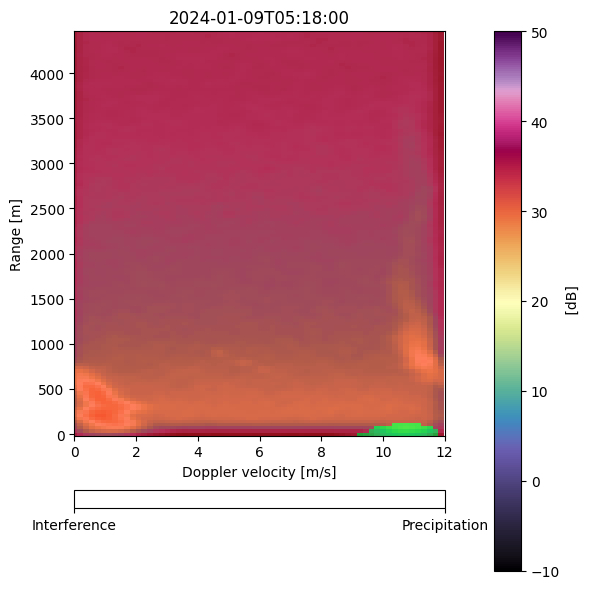

In [473]:
image_time = '2024-01-09T05:18:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


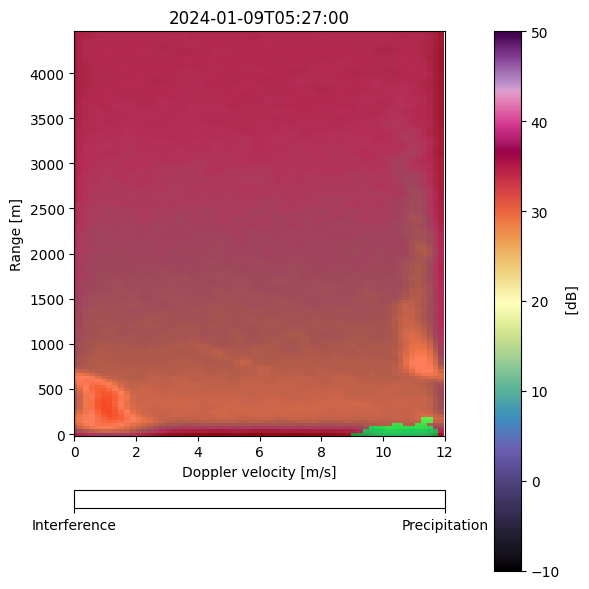

In [474]:
image_time = '2024-01-09T05:27:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


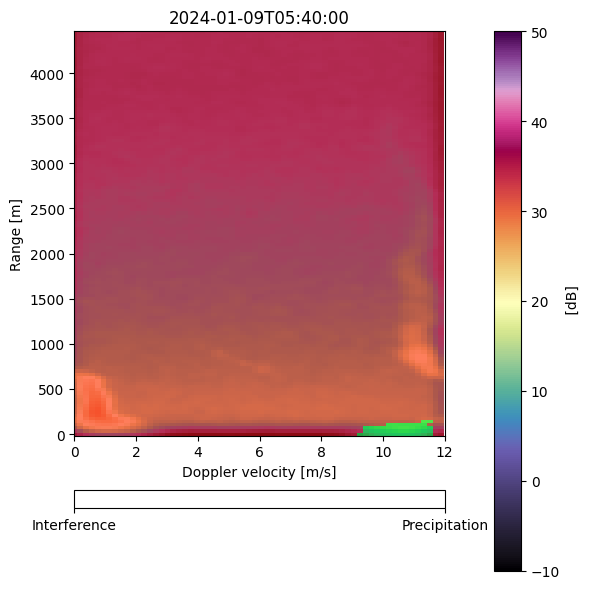

In [475]:
image_time = '2024-01-09T05:40:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


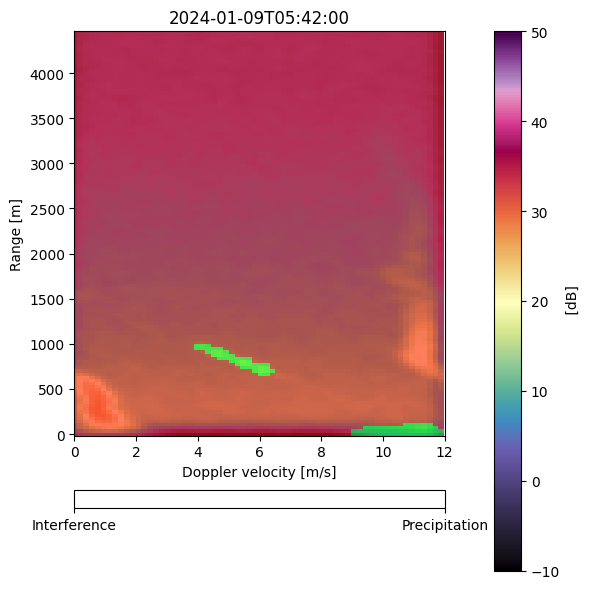

In [476]:
image_time = '2024-01-09T05:42:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


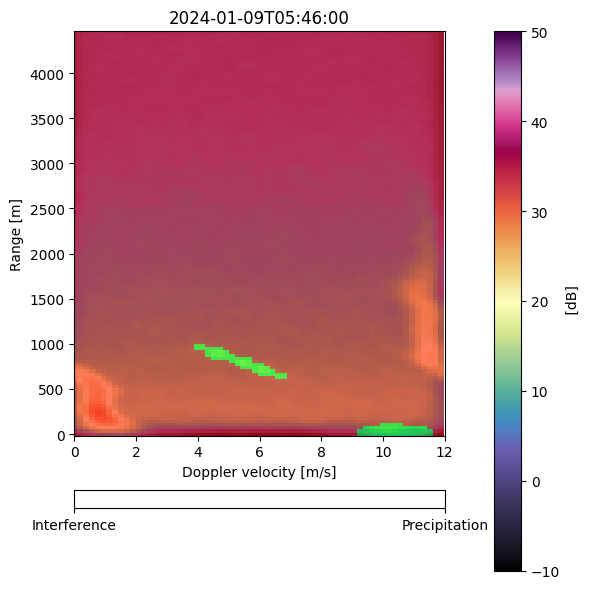

In [477]:
image_time = '2024-01-09T05:46:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


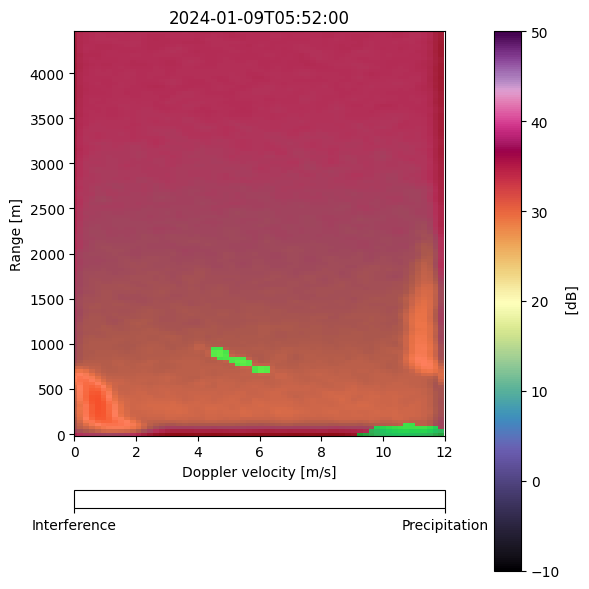

In [478]:
image_time = '2024-01-09T05:52:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


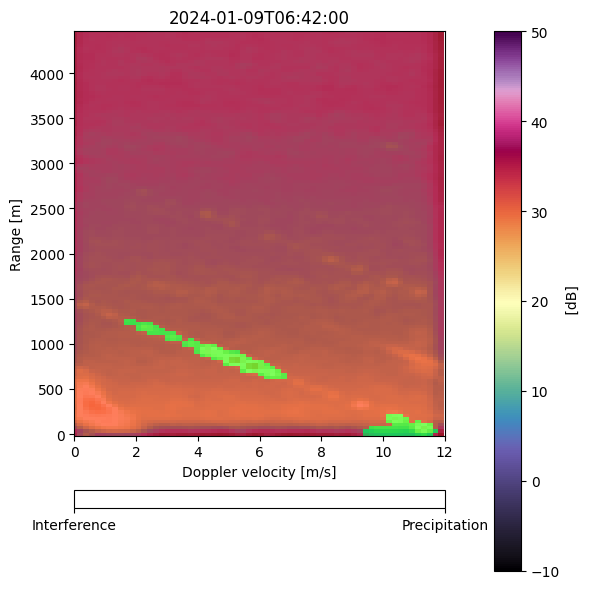

In [479]:
image_time = '2024-01-09T06:42:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


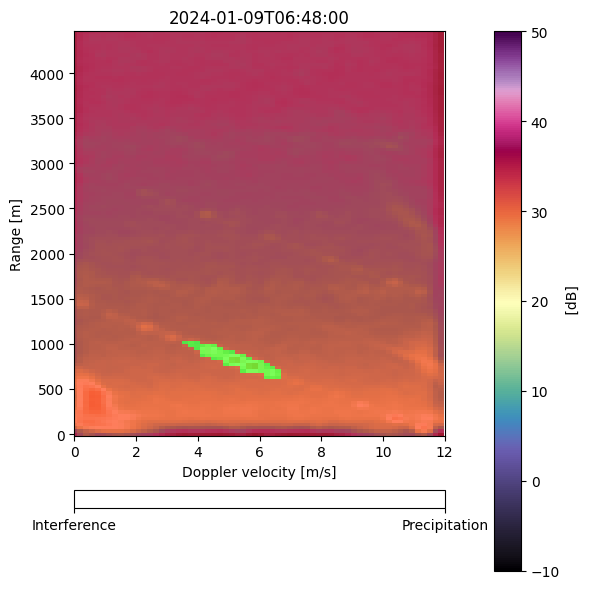

In [480]:
image_time = '2024-01-09T06:48:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


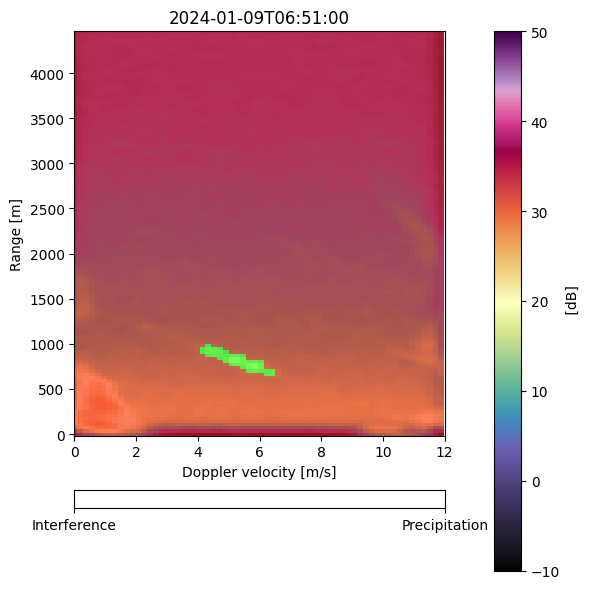

In [481]:
image_time = '2024-01-09T06:51:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


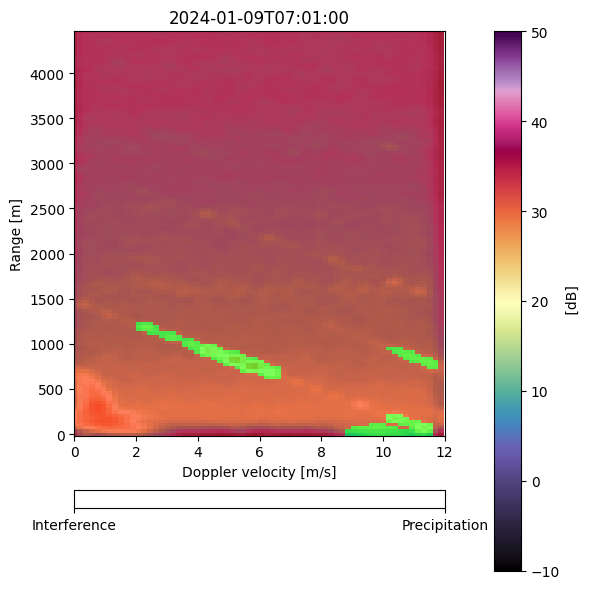

In [482]:
image_time = '2024-01-09T07:01:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


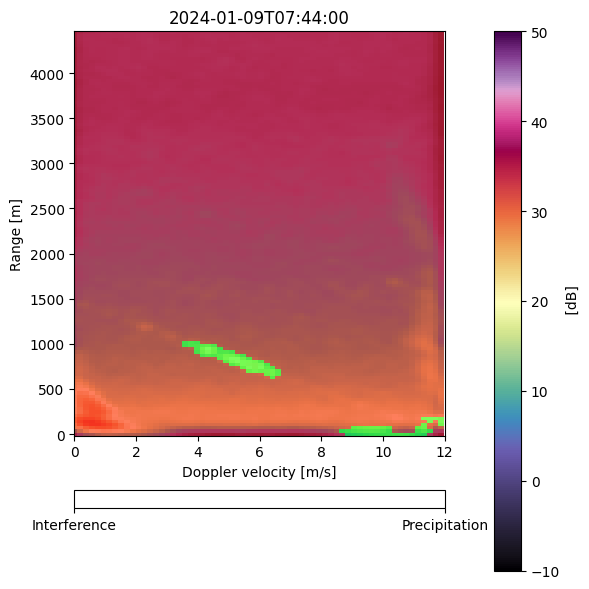

In [483]:
image_time = '2024-01-09T07:44:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


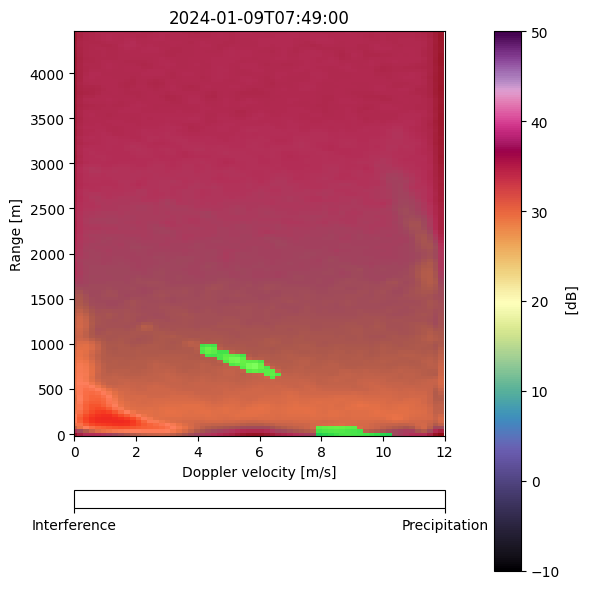

In [484]:
image_time = '2024-01-09T07:49:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2269025326.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2269025326.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


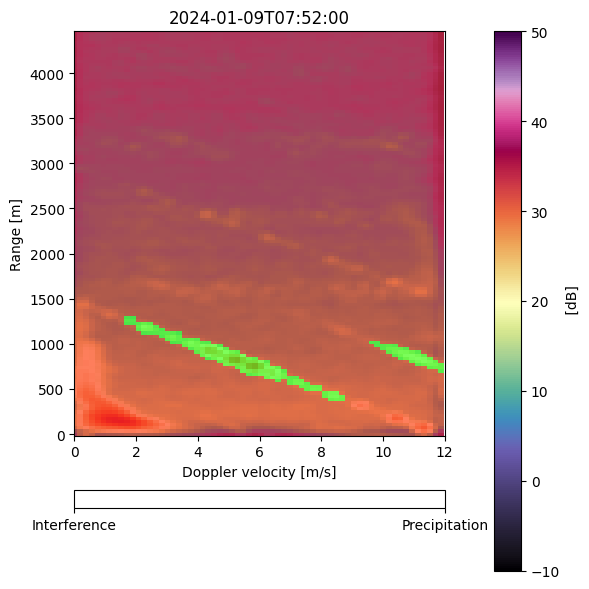

In [525]:
image_time = '2024-01-09T07:52:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


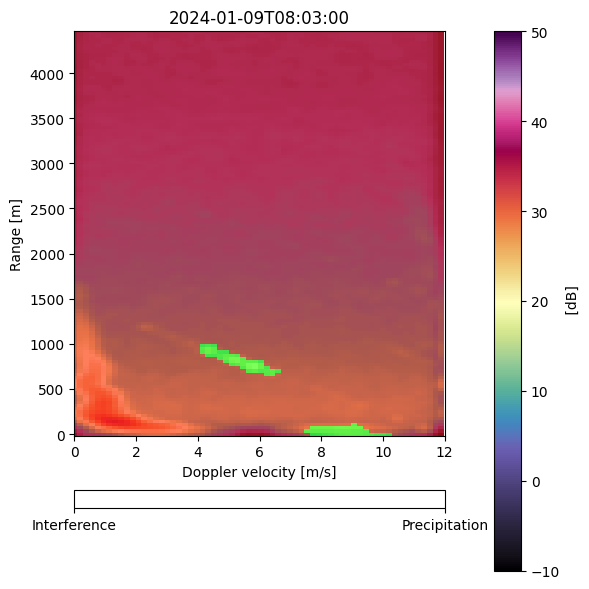

In [486]:
image_time = '2024-01-09T08:03:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


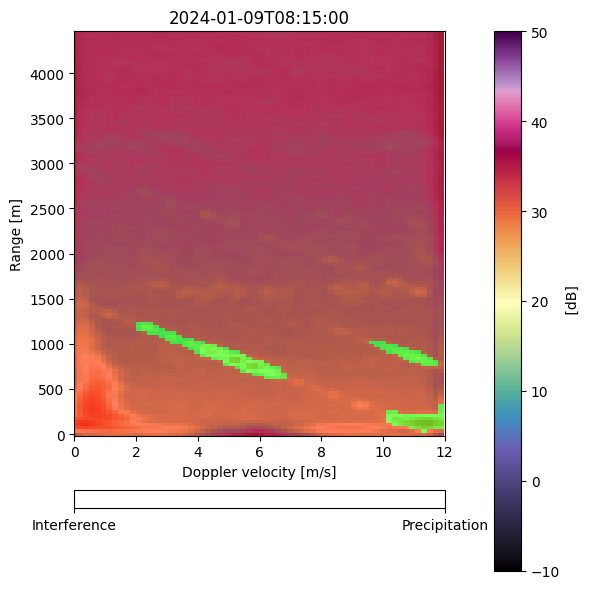

In [487]:
image_time = '2024-01-09T08:15:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


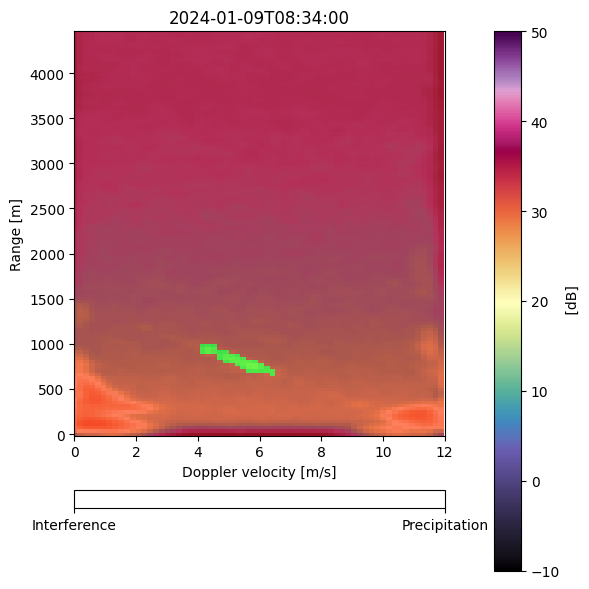

In [488]:
image_time = '2024-01-09T08:34:00'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2503492368.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


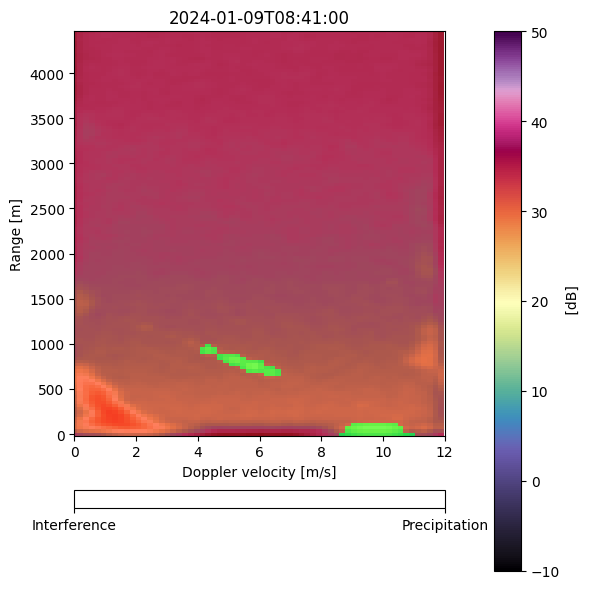

In [489]:
image_time = '2024-01-09T08:41:00'
mask = gen_spectral_masks(image_time)

## Other Times

In [491]:
ds = xr.open_mfdataset('/Users/aabdelbak/20230919/crocus*20230919*.nc')
ds['velocity'] = (['spectrum_n_samples'], np.linspace(0, ds['VEL'].attrs['fold_limit_upper'], 32))
ds['range_spectra'] = (['n_spectra'], ds['range'].values)
ds = ds.set_coords(['range_spectra', 'velocity'])

In [492]:
ds

<xarray.Dataset>
Dimensions:                 (time: 8280, range: 256, sweep: 1, n_spectra: 256,
                             spectrum_n_samples: 32)
Coordinates:
  * range                   (range) float32 0.0 35.0 70.0 ... 8.89e+03 8.925e+03
  * time                    (time) datetime64[ns] 2023-09-19T00:00:00.0093680...
    elevation               (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    azimuth                 (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    velocity                (spectrum_n_samples) float64 0.0 0.1887 ... 5.851
    range_spectra           (n_spectra) float32 0.0 35.0 ... 8.89e+03 8.925e+03
Dimensions without coordinates: sweep, n_spectra, spectrum_n_samples
Data variables: (12/31)
    volume_number           (time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    time_coverage_start     (time) |S128 b'2023-09-19T00:00:00Z' ... b'2023-0...
    time_coverage_end       (time) |S128 b'2023-09-19T00:59:50Z' ... b'2023-0...
    time_reference          (time) |S128 b'1970-01-01T00:00:00Z' ... b'1970-0...
    instrument_type         (time) |S128 b'radar' b'radar' ... b'radar' b'radar'
    transfer_function       (time, range) float64 dask.array<chunksize=(360, 256), meta=np.ndarray>
    ...                      ...
    ML                      (time, range) float64 dask.array<chunksize=(1, 256), meta=np.ndarray>
    SNR                     (time, range) float32 dask.array<chunksize=(1, 256), meta=np.ndarray>
    index_spectra           (time, range) float64 dask.array<chunksize=(1, 256), meta=np.ndarray>
    spectrum_raw            (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(1, 256, 32), meta=np.ndarray>
    N                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(1, 256, 32), meta=np.ndarray>
    D                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(360, 256, 32), meta=np.ndarray>
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data
    institution:      
    references:       
    source:           
    history:          
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      Za,Z,Zea,Ze,RR,LWC,PIA,VEL,WIDTH,SNR,spectrum_reflectiv...

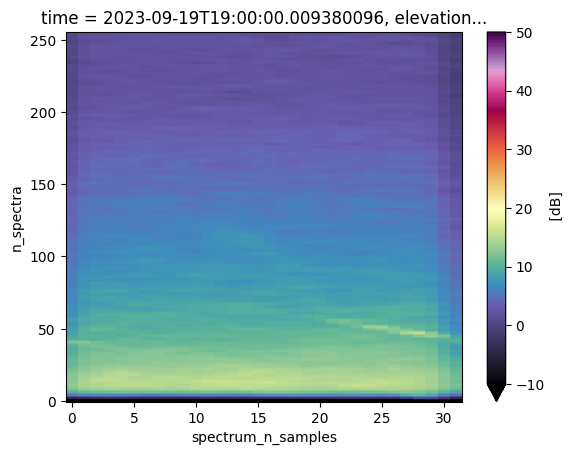

In [493]:
ds['spectrum_raw'].sel(time='2023-09-19T019:00:00').plot(cmap='ChaseSpectral', vmin=-10, vmax=50)

In [494]:
ds['snr_spectrum'] = 10**(ds['spectrum_raw']/10) / 10**(ds['spectrum_raw'].median(dim='spectrum_n_samples')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])

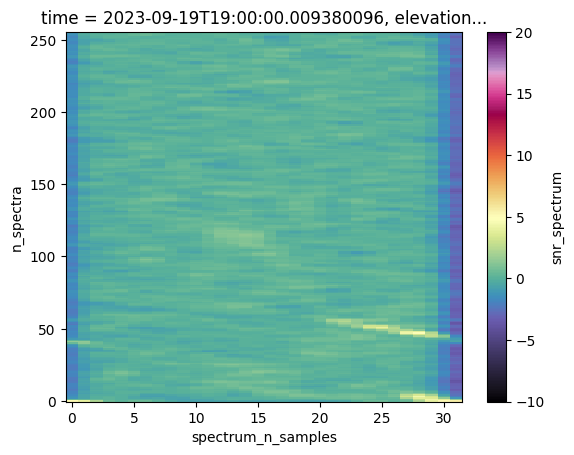

In [495]:
ds['snr_spectrum'].sel(time='2023-09-19T19:00:00').plot(cmap='ChaseSpectral', vmin=-10, vmax=20)

In [498]:
def gen_spectral_masks(image_time):
    input_image = ds['snr_spectrum'].sel(time=image_time).values.squeeze()
    
    # Right now, require the signal-to-noise ratio to be > 1 dB. Adjust as you see fit to include lighter precipitation
    # Be aware that lowering this threshold is more likely to introduce noise as real values, so there is a trade off here!
    input_mask = input_image > 1.5
    label_image = skimage.measure.label(input_mask)

    # Get the properties of each region
    props = skimage.measure.regionprops(label_image)
    mask = label_image.copy()
    label_image = np.zeros_like(mask).astype(float)
    
    orientation = np.array([np.rad2deg(p.orientation) for p in props])
    area = np.array([p.area for p in props])
    major_axis_length = np.array([p.major_axis_length for p in props])
    minor_axis_length = np.array([p.minor_axis_length for p in props])
    axis_ratio = major_axis_length / minor_axis_length
    height = np.array([p.bbox[3] - p.bbox[1] for p in props])

    area_thresh = 25

    # Create Red and blue colormap
    cmap_custom = np.zeros((2, 4))
    cmap_custom[0] = np.array([1., 0., 0., 0])
    cmap_custom[1] = np.array([0., 1., 0., 0])
    cmap_redblue = colors.ListedColormap(cmap_custom, N=2)
    
    ## Insert your criteria here
    # Right now, we are considering any region with > 40 deg orientation and whose longest axis is 3 x the minor axis 
    # To be interference. This covers the coherent noise that appears as diagonal lines. 
    # In addition, we also consider any region with > 70 deg orientation (near horizontal) as interference
    # This covers the random interference that appears as a horizontal region.
    # Precipitation is typically much more vertical in nature in the spectra
    criteria_interference = np.logical_and(np.abs(orientation) > 45, axis_ratio > 4)
    criteria_interference = np.logical_or(criteria_interference, np.abs(orientation) > 80)
    criteria_interference = np.logical_and(criteria_interference, area > area_thresh)
    criteria_precipitation = np.logical_and(np.abs(orientation) < 40, area > area_thresh)
    
    for i, obj in enumerate(props):
        if criteria_interference[i] == True:
            label_image[mask == obj.label] = 1
        elif criteria_precipitation[i] == True:
            label_image[mask == obj.label] = 2
        else:
            label_image[mask == obj.label] = 0
    label_image[label_image == 0] = np.nan
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ds['spectrum_raw'].sel(time=image_time).plot(cmap='ChaseSpectral', vmin=-10, vmax=50, ax=ax, x='velocity', y='range_spectra',
                                            cbar_kwargs={'pad': 0.1})
    x, y = np.meshgrid(ds['velocity'], ds['range_spectra'])
    c = plt.pcolormesh(x, y, label_image, alpha=0.5, cmap=cmap_redblue)
    x, y = np.meshgrid(ds['velocity'], ds['range_spectra'], indexing='ij')
    
    ax.set_title(image_time)
    ax.set_xlim([0, 12])
    ax.set_ylabel('Range [m]')
    ax.set_xlabel('Doppler velocity [m/s]')
    cbar = fig.colorbar(c, ax=ax, orientation="horizontal", pad=0.1)
    cbar.ax.set_xticks([1, 2])
    cbar.ax.set_xlim([1, 2])
    cbar.ax.set_xticklabels(["Interference", "Precipitation"])
    fig.tight_layout()
    time_str = ds['time'].sel(time=image_time).dt.strftime('%Y%m%d.%H%M%S').values
    fig.savefig('interference_masks/%s.png' % time_str[0], bbox_inches='tight')
    print(label_image)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


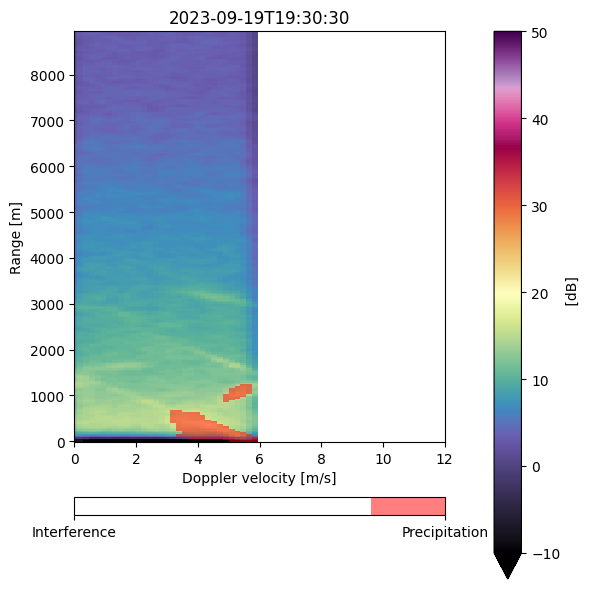

In [499]:
image_time = '2023-09-19T19:30:30'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


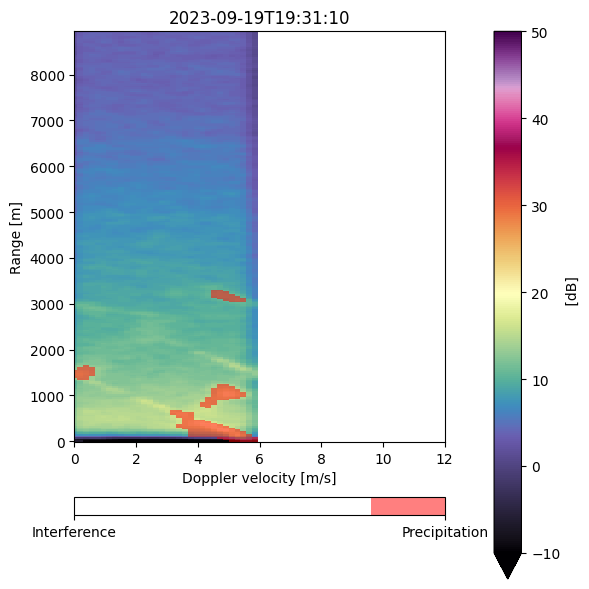

In [500]:
image_time = '2023-09-19T19:31:10'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


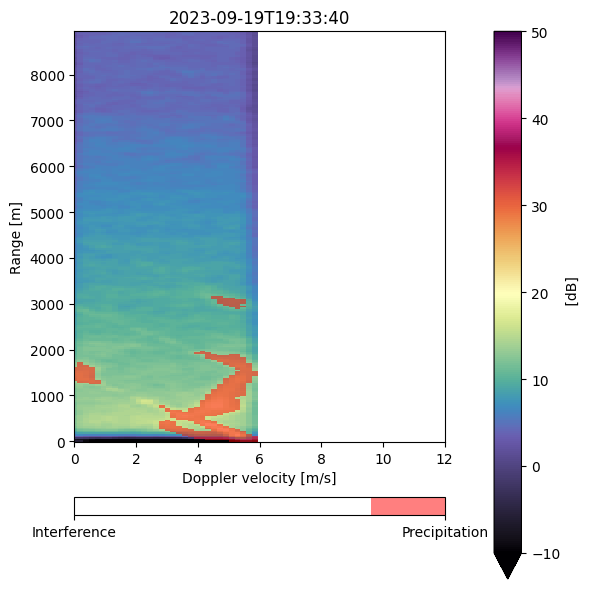

In [501]:
image_time = '2023-09-19T19:33:40'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


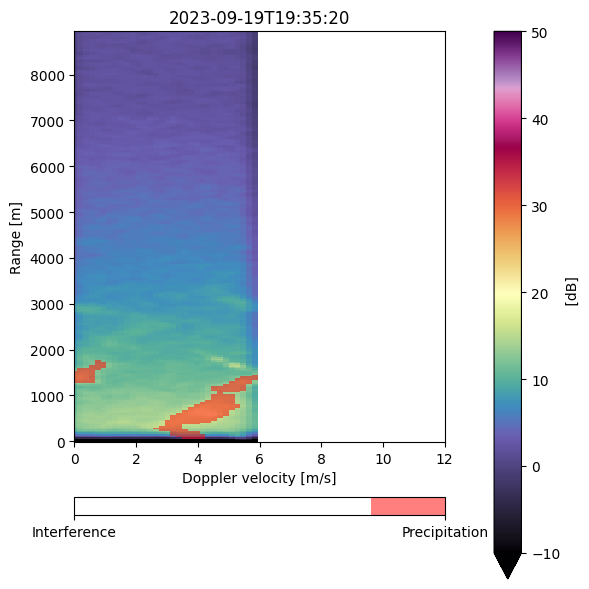

In [502]:
image_time = '2023-09-19T19:35:20'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


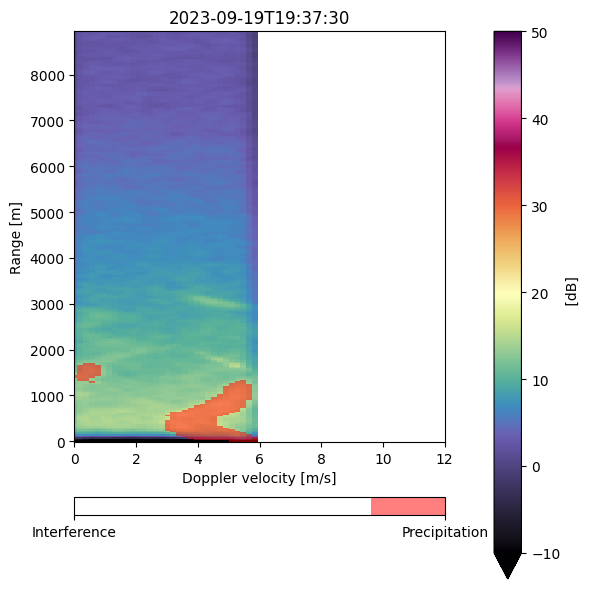

In [503]:
image_time = '2023-09-19T19:37:30'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


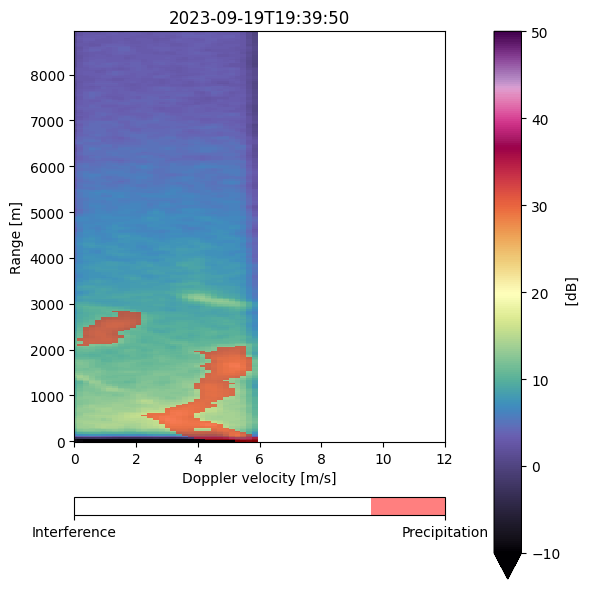

In [504]:
image_time = '2023-09-19T19:39:50'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2. nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


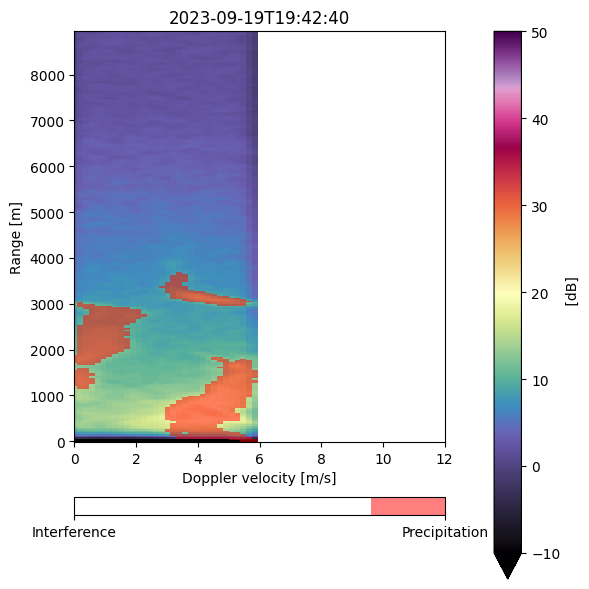

In [505]:
image_time = '2023-09-19T19:42:40'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2. nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


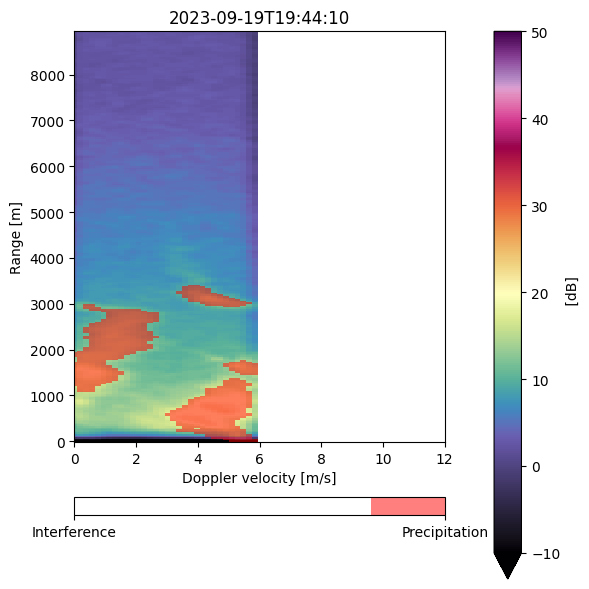

In [506]:
image_time = '2023-09-19T19:44:10'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2. nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


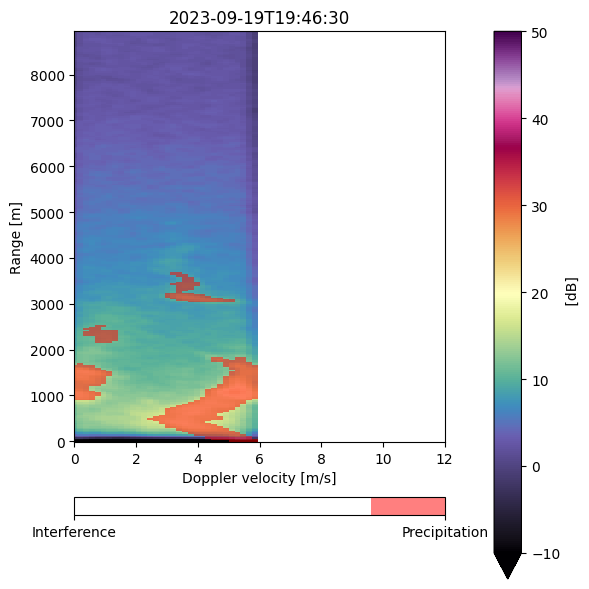

In [507]:
image_time = '2023-09-19T19:46:30'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/2149644576.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


[[nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  2.  2.  2.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


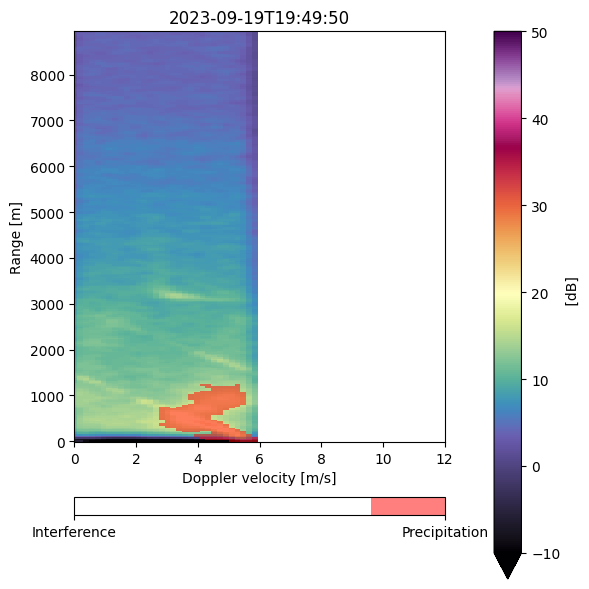

In [508]:
image_time = '2023-09-19T19:49:50'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


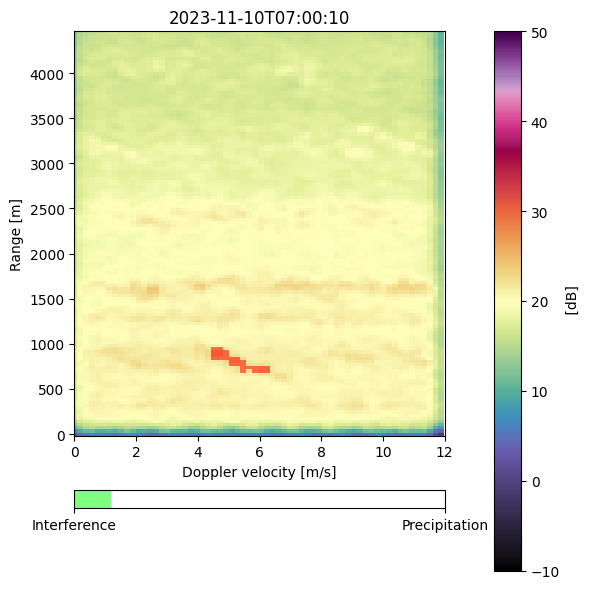

In [297]:
image_time = '2023-11-10T07:00:10'
mask = gen_spectral_masks(image_time)

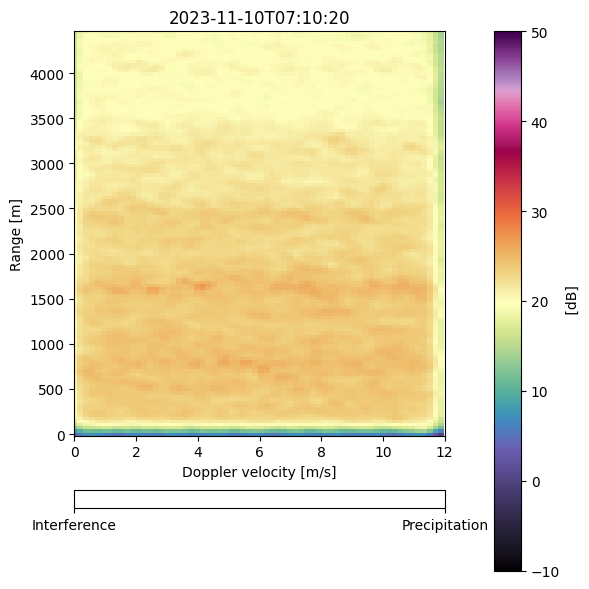

In [298]:
image_time = '2023-11-10T07:10:20'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


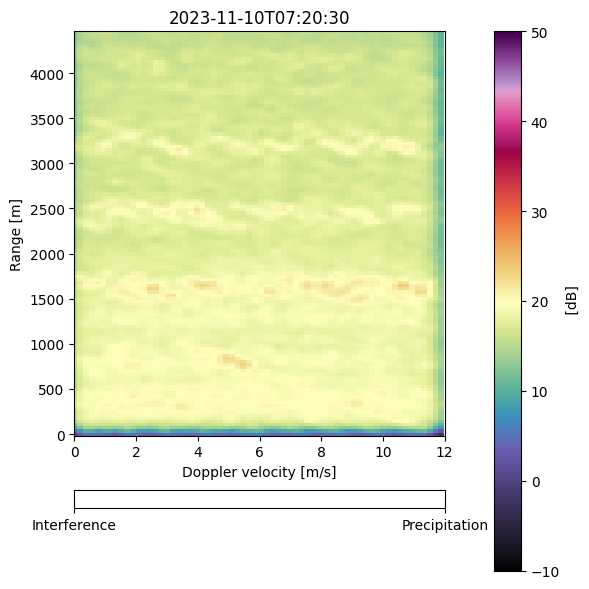

In [299]:
image_time = '2023-11-10T07:20:30'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


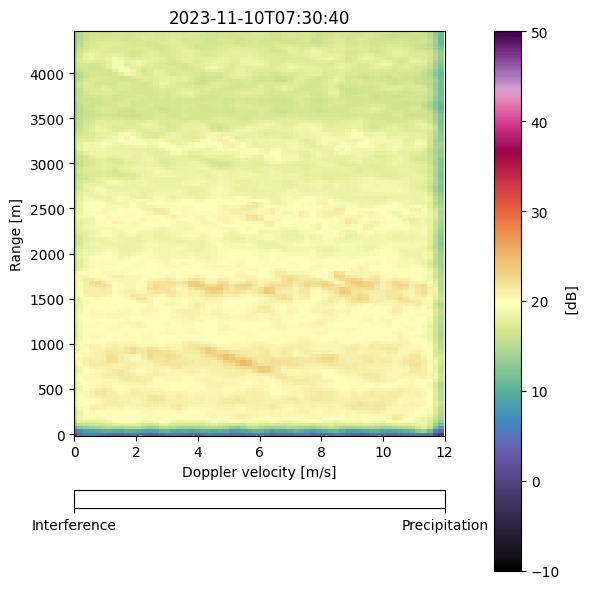

In [300]:
image_time = '2023-11-10T07:30:40'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length
/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3210744296.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


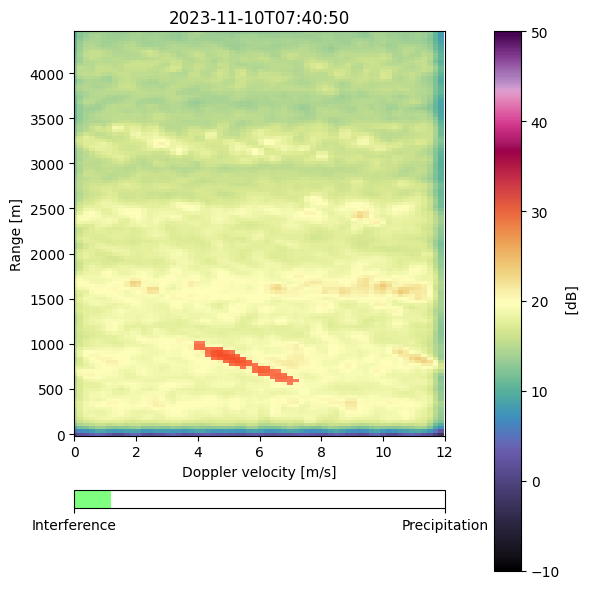

In [301]:
image_time = '2023-11-10T07:40:50'
mask = gen_spectral_masks(image_time)

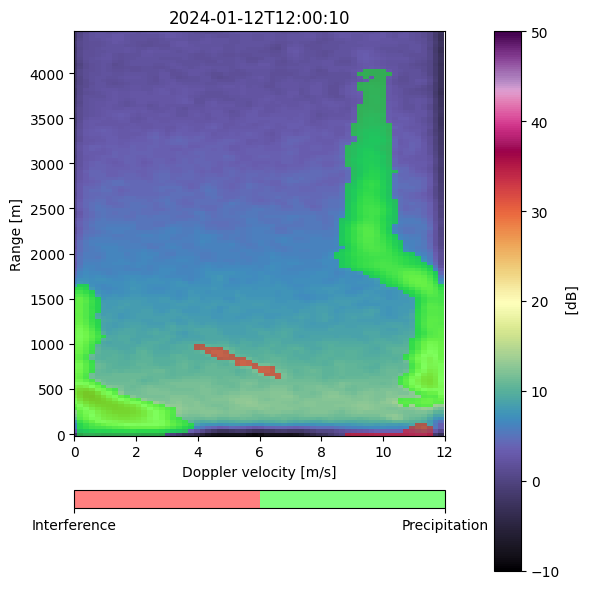

In [314]:
image_time = '2024-01-12T12:00:10'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3530126420.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


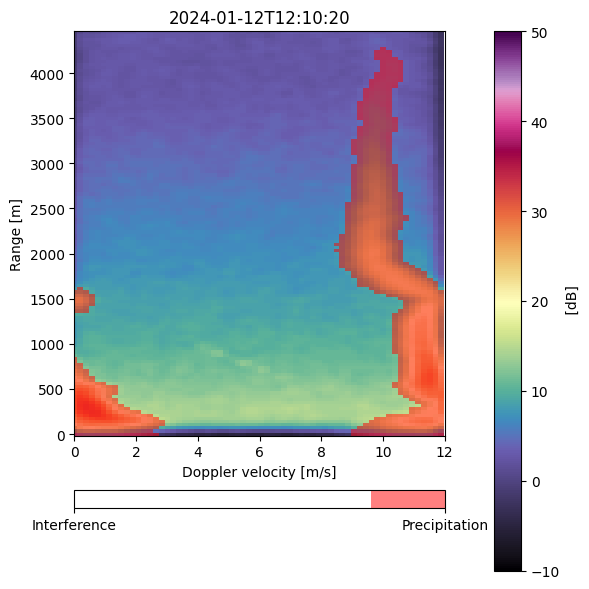

In [315]:
image_time = '2024-01-12T12:10:20'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3530126420.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


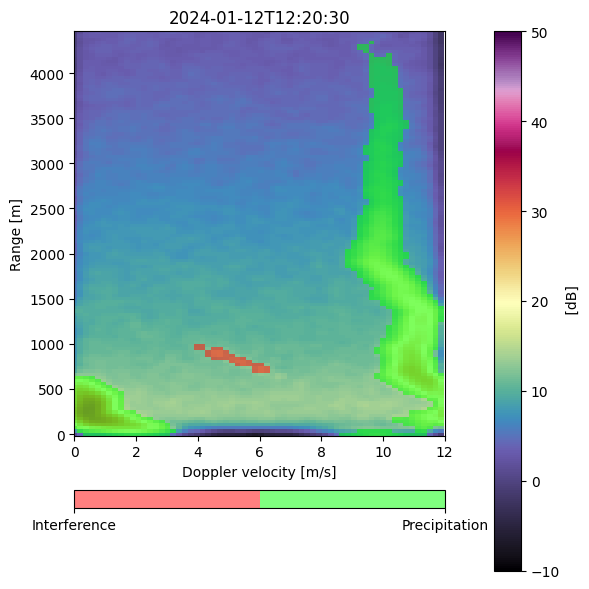

In [316]:
image_time = '2024-01-12T12:20:30'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3530126420.py:18: RuntimeWarning: divide by zero encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


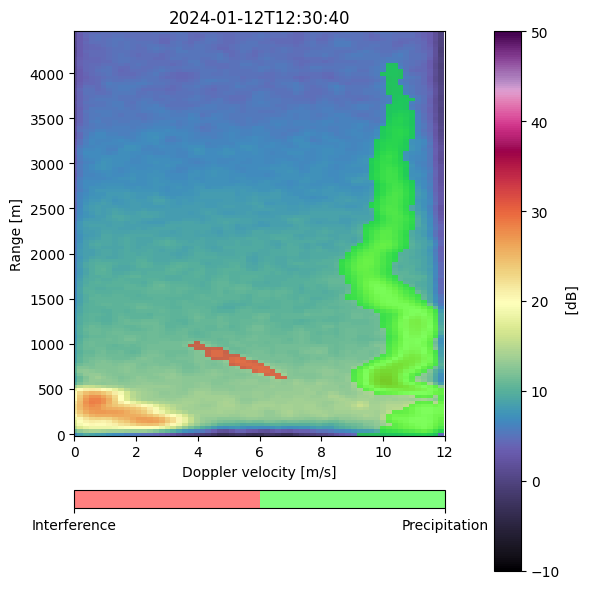

In [317]:
image_time = '2024-01-12T12:30:40'
mask = gen_spectral_masks(image_time)

/var/folders/tk/773qlzjx69v8hvb828lg9xdc0000gp/T/ipykernel_95838/3530126420.py:18: RuntimeWarning: invalid value encountered in divide
  axis_ratio = major_axis_length / minor_axis_length


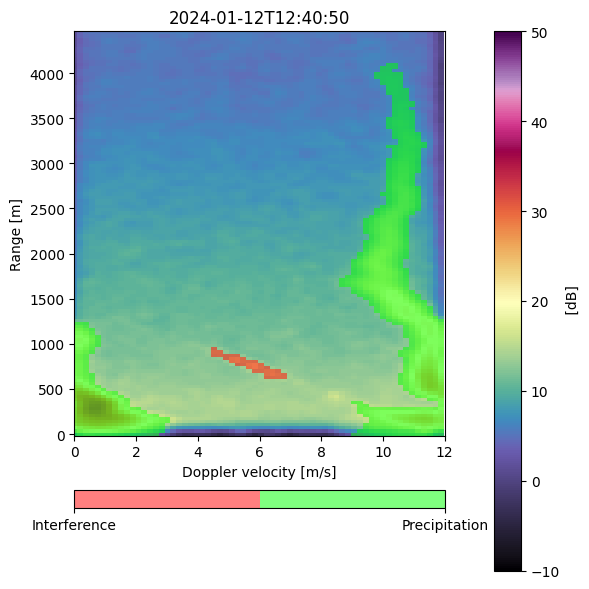

In [318]:
image_time = '2024-01-12T12:40:50'
mask = gen_spectral_masks(image_time)